This notebook is motivated by an awesome Boston Bayesian meetup in June 2017, by Colin Carroll, https://github.com/ColCarroll




Leapfrog is an important step in Hamiltonian Monte Carlo (HMC). The algorithm uses Hamiltonian dynamics to find the paths that are coherent to the target distribution's ``typical sets.'' 

The Hamilton's equations read as:
\begin{array}{}
\dfrac{dq}{dt} &=& \dfrac{\partial \mathcal{H}}{\partial p}\\
\dfrac{dp}{dt} &=& - \dfrac{\partial \mathcal{H}}{\partial q},
\end{array}
where $q$ is the position, representing our target variable, p the momentum, being introduce in HMC to faciliate the search path.


Assuming the Hamiltonian takes the following form:
\begin{equation}    
\mathcal{H} = \dfrac{p^2}{2} + \dfrac{q^2}{2},
\end{equation}
then the Hamilton's equations can be written as:
\begin{array}{}
\dfrac{dq}{dt} &=&  \dfrac{\partial \mathcal{H}}{\partial p} &=& p \\
\dfrac{dp}{dt} &=& - \dfrac{\partial \mathcal{H}}{\partial q} &=& -q,
\end{array}

The Hamilton's equations allow us to perform numerical integral to obtian $(q_T, p_T)$, given an initial point in the phase space $(q_0, p_0)$ and an integration time $T$. The leapfrog algorithm reads as the following:

\begin{array}{}
p(t + \epsilon/2) &=& p(t) - \dfrac{\epsilon}{2} q(t) \\
q(t + \epsilon) &=& q(t) + \epsilon p(t + \epsilon/2) \\
p(t + \epsilon) &=& p(t + \epsilon/2) - \dfrac{\epsilon}{2} q(t + \epsilon)
\end{array}

Below we will assume that $q, p$ follow a two dimensional Normal distributin $\mathcal{N}(0, 1)$ and generate a few representative leapfrog paths.

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sbn
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
def generateData(q_generator, p_generator, n=1000):
    q = q_generator.rvs(n)    
    p = p_generator.rvs(n)
    return np.column_stack([q, p])

In [3]:
q_generator = scipy.stats.norm(0, 1)
p_generator = scipy.stats.norm(0, 1)
X = generateData(q_generator, p_generator, 5000)

In [4]:
def leapfrog(q, p, dHdq, dHdp, epsilon, T):
    """
    Arguments:
        q -- initial position q_0
        p -- initial momentum p_0
        dHdq -- a function that calculates the partial derivative of the Hamiltonian wrt q
        dHdp -- a function that calculates the partial derivative of the Hamiltonian wrt p
        epsilon -- step size
        T -- integration time
    Return:
        path -- the leapfrog path corresponding to integrating from (q_0, p_0) to (q_T, p_T)
    """
    data = [[q, p]]
    p += 0.5 * epsilon * (-dHdq(q, p))
    q += epsilon * dHdp(q, p)
    data.append([q, p])
    for _ in range(T-1):
        p += epsilon * (-dHdq(q, p))
        q += epsilon * dHdp(q, p)
        data.append([ q, p])
    p += 0.5 * epsilon * (-dHdq(q, p))
    data.append([q, p])
    return np.array(data)

In [5]:
def generateLeapfrogPaths(q_generator, p_generator, dHdq, dHdp, n_paths=10):
    q = q_generator.rvs()
    p = p_generator.rvs()
    for _ in range(n_paths):
        path = leapfrog(q, p, dHdq, dHdp, 0.01, 100)
        yield path
        q, _ = path[-1]
        p = p_generator.rvs()

In [6]:
dHdq = lambda q, p: q
dHdp = lambda q, p: p

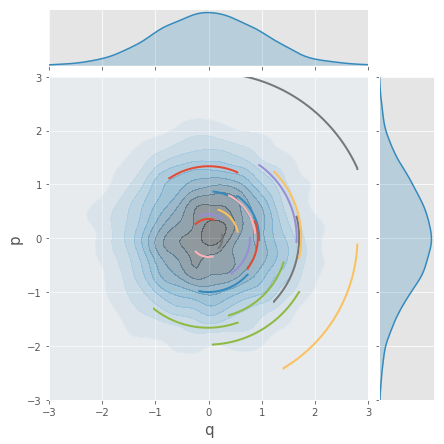

In [8]:
g = sbn.jointplot(*X.T, kind='kde', stat_func=None, xlim=(-3, 3), ylim=(-3, 3), alpha=0.4, color="#348ABD")
for path in generateLeapfrogPaths(q_generator, p_generator, dHdq, dHdp, n_paths=20):
    g.ax_joint.plot(*path.T, lw=2)
_ = g.ax_joint.set_xlabel('q', fontsize=15, labelpad=5)    
_ = g.ax_joint.set_ylabel('p', fontsize=15, labelpad=5)